# TOGGLE SWITCH MODEL <p><left>by **Kaustubh Kadam**</left></p>

In [1]:
import numpy as np
from scipy import *
from scipy.integrate import ode
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import least_squares

In [2]:
def diff_eq(t,metabolite,parameters):
    Km=1 #michelis menton constant for PPV formation
    kdegpcb=parameters[3]      #degradation rate of PCB
    kdegppv=parameters[4]      #degradation rate of PPV
    kdegrna=parameters[5]      #degradation rate of RNA
    kformppv=2.8E-2*3600       #rate constant for PPV formation
    ktc=parameters[6]          #transcription rate of RNA
    Kmrna=parameters[7]        #michelis menton constant for RNA formation
    kbasal=parameters[8]       #basal leaky RNA expression
    kout=parameters[9]        #protein diffusion into media
    ktlppre=parameters[10]     #ppre translation
    ktlmcherry=parameters[11]  #mcherry translation rate
    kdegmcherry=parameters[12] #mcherry degradation rate
    trigger=parameters[1]      #light switch
    killswitch=parameters[2]   #tetracycline addition time
    if t>trigger and (t<killswitch or killswitch<0): #light trigger response
        klight=1
    else:
        klight=0
                
    phyb0=parameters[0] #total phyb present
    dmetabolite=np.zeros([5]) #generating derivative array
    [pcb,ppv,rna,ppre,mcherry]=metabolite #metabolite assignment
    dmetabolite[0]=-kformppv*(phyb0-ppv)*pcb/(Km+pcb)-kdegpcb*pcb #dpcb/dt
    dmetabolite[1]=kformppv*(phyb0-ppv)*pcb/(Km+pcb)-kdegppv*ppv #dppv/dt
    dmetabolite[2]=ktc*ppv/(Kmrna+ppv)*klight+kbasal-kdegrna*rna #drna/dt
    dmetabolite[3]=ktlppre*rna-kout*ppre  #dppre/dt
    dmetabolite[4]=ktlmcherry*ppre-kdegmcherry*mcherry #dmcherry/dt
    
    return dmetabolite
    

In [3]:

def model(optim_params):
    phyb0=10**(-1.545) #PhyB total concentration
    [kdegpcb,kdegppv,kdegrna,ktc,Kmrna,
     kbasal,kout,ktlppre,ktlmcherry,kdegmcherry]=optim_params #difining mcherry constants
    pcb0=15    #PCB initial concentration
    ppv0=0     #PPV initial concentration
    rna0=0     #RNA initial concentration
    ppre0=0    #PPre initial concentration
    mcherry0=0 #mCherry initial concentration
    t0 = 0; tEnd = 22.0; dt = 0.01 #time and time step
    trigger=0 #start light induction ON kinetics begin
    killswitch=trigger+90/60 #tetracycline addition OFF kinetics begin
    metabolite0 = [pcb0,ppv0,rna0,ppre0,mcherry0] #Initial conditions
    Y=[]; T=[]  #create empty lists
    parameters=[phyb0,trigger,killswitch,kdegpcb,kdegppv,kdegrna,
                ktc,Kmrna,kbasal,kout,ktlppre,ktlmcherry,kdegmcherry]  #parameters for odes

    eq = ode(diff_eq).set_integrator('dopri5') #ode with runge kutta solver 
    eq.set_f_params(parameters).set_initial_value(metabolite0,t0) #initialvalues and parameters
    while eq.successful() and eq.t+dt < tEnd:
        eq.integrate(eq.t+dt)
        Y.append(eq.y)        #makes a list of 1d arrays
        T.append(eq.t)       #makes a list of time increments

    Y = array(Y)        #convert from list to 2d array
    T = array(T)        #convert from list to 2d array
    T = around(T,2)     #round 2 decimal numbers
    return Y,T
def optim(optim_params,obs_time,obs_fl): 
    #optim_params= parameters to be optimized
    #obs_time= timestamp of experimental observation
    #obs_fl=experimental flurescence
    [Y,T]=model(optim_params) #import model output
    #separate model output into individual metabolite concentration
    PCB=Y[:,0] #PCB
    PPV=Y[:,1] #PPV
    RNA=Y[:,2] #RNA
    PPRE=Y[:,3] #PPRE
    MCHERRY=Y[:,4] #Mcherry
    model_fl=[] #create null list to populate model fluorescence corresponding to observed time
    for i in range (0,len(obs_time)): 
        for j in range (0,len(T)):
            if obs_time[i]==T[j]:
                model_fl.append(MCHERRY[j]) #append model fluorescence at observed time to list 
    model_fl=array(model_fl) #convert list to array
    #print(len(model_fl),len(obs_fl))
    return model_fl-obs_fl #return the error in model prediction which forms the objective of our optimization function

trigger=0 #start light induction ON kinetics begin
killswitch=trigger+90/60 #tetracycline addition OFF kinetics begin
obs_time=np.array([3,10,20,30,40,50,60,70,80,90,1200]) #time of experimental observation in minutes
obs_time=obs_time/60
obs_time=trigger+around(obs_time,2) #shift data to account for difference between PCB addition and light induction
obs_fl=np.array([0,0.069249499,0.332629626,0.355316444,0.282949526,0.247138294,
                0.197883962,0.159583336,0.13478094,0.105941567,0.094092046]) #experimental flurescence
obs_fl=obs_fl*100
kdegpcb0=10**(-0.158) #initial degradation rate of PCB
kdegppv0=10**(-0.756) #initial degradation rate of PPV
kdegrna0=10**(-0.551) #initial degradation rate of RNA
ktc0=10**(3) #initial transcription rate of RNA
Kmrna0=10**(-0.196) #initial michelis menton constant for RNA formation
kbasal0=10**(-0.625) #initial basal leaky RNA expression
kout0=10**(-0.869) #initial protein diffusion into media
ktlppre0=10**(0.866) #initial ppre translation
ktlmcherry0=10**(-1.958) #initial guess for mcherry translation rate
kdegmcherry0=10**(1.035) #initial guess for mcherry degradation rate

init_guess=[kdegpcb0,kdegppv0,kdegrna0,ktc0,Kmrna0,kbasal0,
            kout0,ktlppre0,ktlmcherry0,kdegmcherry0] #list of initial iteration
res_mcherry = least_squares(optim, init_guess, bounds=(0, 10000), 
                            args=(obs_time, obs_fl), verbose=1,xtol=1e-5,ftol=1e-5) #least square optimization function
mcherryparams=res_mcherry.x #optimized parameters, output of least square optimization
print(mcherryparams)

`ftol` termination condition is satisfied.
Function evaluations: 297, initial cost: 2.4112e+03, final cost 1.9369e+01, first-order optimality 3.99e+03.
[  3.82335311e+01   3.53266222e+00   9.52999988e+00   1.00327889e+03
   1.02979111e-01   4.49612246e+01   9.54586641e+00   1.42122812e+01
   1.34168325e+01   9.57151843e+00]


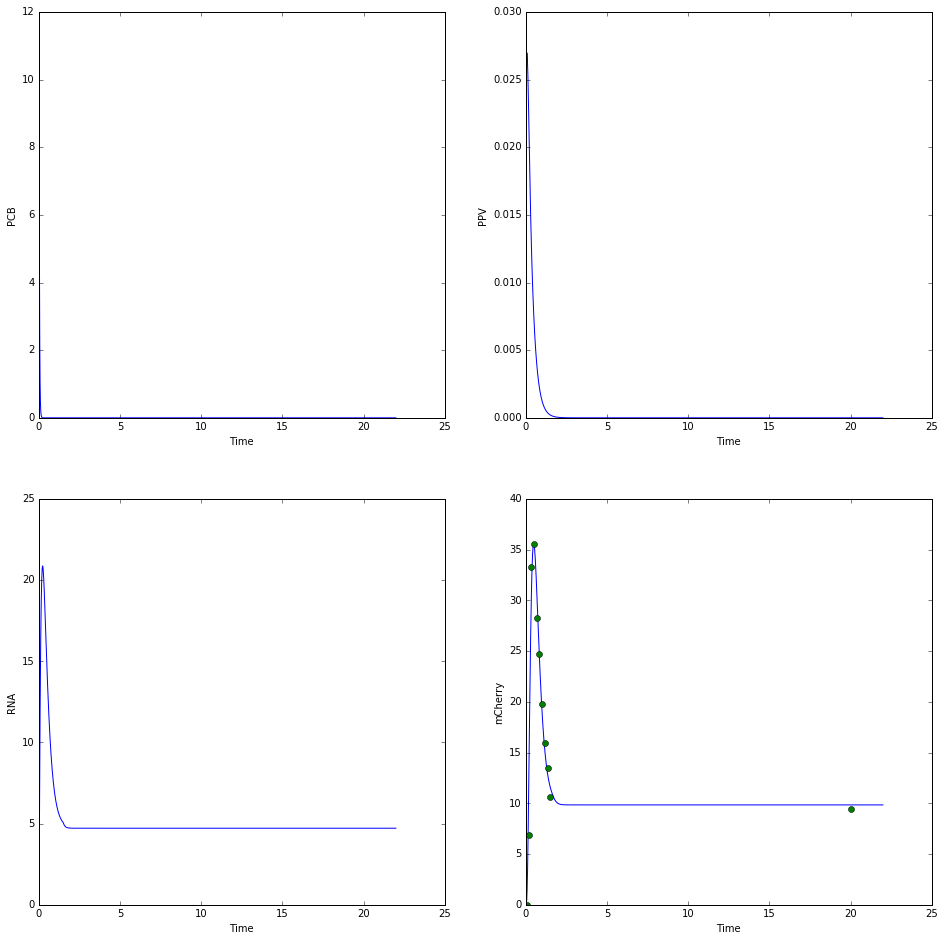

In [4]:
import numpy as np
import matplotlib.pyplot as plt

[Y,T]=model(mcherryparams)
PCB=Y[:,0]
PPV=Y[:,1]
RNA=Y[:,2]
PPRE=Y[:,3]
MCHERRY=Y[:,4]
fig = plt.figure(figsize=(16, 16), dpi=260)

ax1 = fig.add_subplot(221)
ax1.plot(T, PCB, "-")
ax1.set_xlabel('Time')
ax1.set_ylabel('PCB')

ax2 = fig.add_subplot(222)
ax2.plot(T, PPV, "-")
ax2.set_xlabel('Time')
ax2.set_ylabel('PPV')

ax3 = fig.add_subplot(223)
ax3.plot(T, RNA, "-")
ax3.set_xlabel('Time')
ax3.set_ylabel('RNA')

ax4 = fig.add_subplot(224)
ax4.plot(T, MCHERRY, "-")
ax4.plot(obs_time,obs_fl,"o")
ax4.set_xlabel('Time')
ax4.set_ylabel('mCherry')

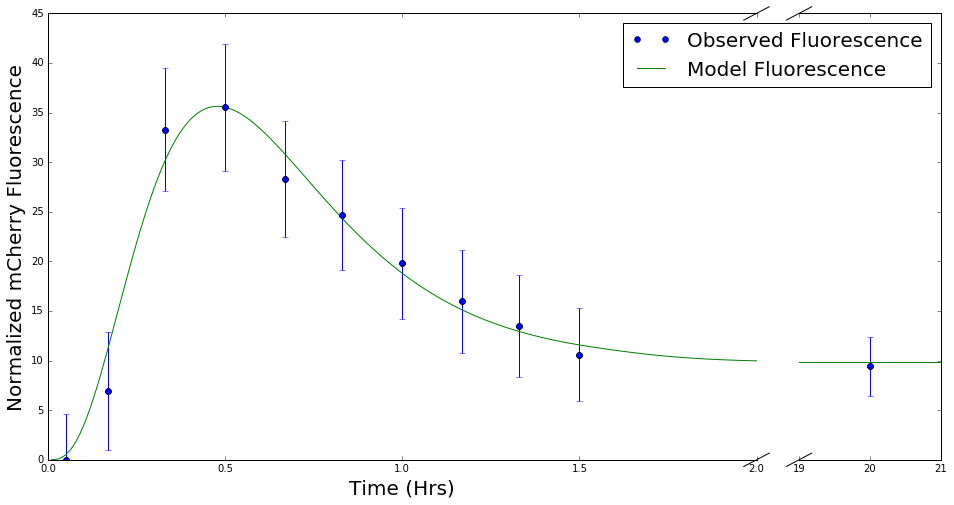

In [8]:
import matplotlib.pylab as plt
import numpy as np
import matplotlib.gridspec as gridspec

x1 = obs_time
x2 = T

y1 = obs_fl
y2 = MCHERRY
yerr=np.array([0.046390004,0.059510881,0.062075465,0.063790102,0.058309439,
               0.05556501,0.055682084,0.051948624,0.051784315,0.047136253,0.029999472])
yerr=yerr*100
n = 5; m = 1;
gs = gridspec.GridSpec(1,2, width_ratios = [n,m])

plt.figure(figsize=(16,8))

ax = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharey = ax)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.subplots_adjust(wspace = 0.1)

ax.plot(x1, y1,"o",label='Observed Fluorescence', color='blue')
ax.plot(x2, y2,label='Model Fluorescence', color='green')
ax.errorbar(x1, y1, yerr=yerr,color='blue', fmt='o')
ax2.plot(x1, y1,'o',label='Observed Fluorescence', color='blue')
ax2.plot(x2, y2,label='Model Fluorescence', color='green')
ax2.errorbar(x1, y1, yerr=yerr,color='blue', fmt='o')
ax.set_ylim(0,45)
ax.set_xlim(0,trigger+2)
ax2.set_xlim(trigger+19,trigger+21)
legend = ax2.legend(loc='upper right',fontsize=20)
# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright='off')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.set_xlabel('Time (Hrs)')
ax.set_ylabel('Normalized mCherry Fluorescence')

ax2.yaxis.tick_right()
ax2.tick_params(labelright='off')
ax2.set_xticks([trigger+19,trigger+20,trigger+21])

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)

on = (n+m)/n; om = (n+m)/m;
ax.plot((1-d*on,1+d*on),(-d,d), **kwargs) # bottom-left diagonal
ax.plot((1-d*on,1+d*on),(1-d,1+d), **kwargs) # top-left diagonal
kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((-d*om,d*om),(-d,d), **kwargs) # bottom-right diagonal
ax2.plot((-d*om,d*om),(1-d,1+d), **kwargs) # top-right diagonal
savefig('plot_trial2.png')
plt.show()

In [6]:
import pandas as pd
constant_labels=['kdegpcb','kdegppv','kdegrna','kformppv','ktc','Kmrna','kbasal',
            'kout','ktlppre','ktlmcherry','kdegmcherry']
init_guess_list=list(init_guess)
init_guess_list.insert(3,2.8E-2*3600)
mcherryparams_list=list(mcherryparams)
mcherryparams_list.insert(3,2.8E-2*3600)
rate_constants=list(zip(constant_labels,init_guess_list,mcherryparams_list))

df = pd.DataFrame(data = rate_constants, columns=['','Initial Guess', 'Optimized values'])
df.to_excel('Trial 2 rateconstants.xlsx')
df

,,Initial Guess,Optimized values
0,kdegpcb,0.695024,38.233531
1,kdegppv,0.175388,3.532662
2,kdegrna,0.281190,9.530000
3,kformppv,100.800000,100.800000
4,ktc,1000.000000,1003.278890
5,Kmrna,0.636796,0.102979
6,kbasal,0.237137,44.961225
7,kout,0.135207,9.545866
8,ktlppre,7.345139,14.212281
9,ktlmcherry,0.011015,13.416832
